In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
# file with velocities
rawVelFileName = "../data/test-vels-north.txt"
# need to format the file appropritely, before we can read it
outFormattedFile = "../data/formatted-vels.txt"
# os.system( 'cat ' + rawVelFileName + ' | tr -s "  " > ' + outFormattedFile )
inpColNames = [ "dateStr", "timeStr", "beam", "range", \
          "azim", "Vlos", "MLAT", "MLON", "MLT", "radId", \
          "radCode"]
velsDataDF = pandas.read_csv(outFormattedFile, sep=' ',\
                             header=None, names=inpColNames)
# add a datetime col
velsDataDF["date"] = pandas.to_datetime( \
                        velsDataDF['dateStr'].astype(str) + "-" +\
                        velsDataDF['timeStr'].astype(str), format='%Y%m%d-%H%M')
# for some reason MLAT is a str type, convert it to float
velsDataDF["MLAT"] = velsDataDF["MLAT"].astype(float)
# Also get a normMLT for plotting
velsDataDF['normMLT'] = [x-24 if x >= 12 else x for x in velsDataDF['MLT']]
velsDataDF.head()
#### In this block we load SAPS Velocity data ####
#### In this block we load SAPS Velocity data ####
#### In this block we load SAPS Velocity data ####

,dateStr,timeStr,beam,range,azim,Vlos,MLAT,MLON,MLT,radId,radCode,date,normMLT
0,20110409,600,0,26,-60.95,-2.2716,53.2044,-21.8611,23.6993,33,bks,2011-04-09 06:00:00,-0.3007
1,20110409,600,0,27,-60.95,-5.1056,53.3065,-22.5771,23.6515,33,bks,2011-04-09 06:00:00,-0.3485
2,20110409,600,0,28,-60.95,-5.1056,53.4035,-23.2954,23.6036,33,bks,2011-04-09 06:00:00,-0.3964
3,20110409,600,0,29,-60.95,-4.5666,53.4954,-24.0159,23.5556,33,bks,2011-04-09 06:00:00,-0.4444
4,20110409,600,0,30,-60.95,-3.6944,53.5823,-24.7384,23.5074,33,bks,2011-04-09 06:00:00,-0.4926


In [3]:
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
# remove velocies whose magnitude is less than 200 m/s
velsDataDF = velsDataDF[ abs(velsDataDF["Vlos"]) >= 200. ]
# SAPS(westward) Vlos are positive for positive azimuths and vice versa.
# filter the others out
velsDataDF = velsDataDF[ velsDataDF["azim"]/velsDataDF["Vlos"] > 0. ].reset_index(drop=True)
velsDataDF.head()
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####

,dateStr,timeStr,beam,range,azim,Vlos,MLAT,MLON,MLT,radId,radCode,date,normMLT
0,20110409,706,9,28,-26.21,-244.3651,59.1492,-14.0168,1.3205,33,bks,2011-04-09 07:06:00,1.3205
1,20110409,706,10,28,-22.35,-244.3651,59.5371,-12.4132,1.4274,33,bks,2011-04-09 07:06:00,1.4274
2,20110409,708,9,27,-26.21,-226.6634,58.8263,-13.5483,1.3848,33,bks,2011-04-09 07:08:00,1.3848
3,20110409,708,10,27,-22.35,-226.6634,59.1965,-12.0037,1.4878,33,bks,2011-04-09 07:08:00,1.4878
4,20110409,730,8,27,-30.07,-257.8685,58.3937,-14.9997,1.6560,33,bks,2011-04-09 07:30:00,1.6560


In [4]:
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
datFileName = "../data/processedSaps.txt"
sapsDataDF = pandas.read_csv(datFileName, sep=' ', dtype={'dateStr':'str', 'time': 'str'})

sapsDataDF["date"] = pandas.to_datetime( \
                        sapsDataDF['dateStr'] + "-" +\
                        sapsDataDF['time'], format='%Y%m%d-%H%M')
sapsDataDF.head()
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####

,dateStr,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT,dst_date,dst_index,time,date
0,20110107,56.5,17.7543,308.2077,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
1,20110107,55.5,18.0147,224.1588,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
2,20110107,56.5,17.8749,307.4328,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
3,20110107,55.5,18.1324,222.4787,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07
4,20110107,56.5,17.9955,305.4201,33,62.0082,18,2011-01-07 00:00:00,-18,0000,2011-01-07


In [5]:
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
# we choose 0840 UT since that time was analyzed in the paper
timeSlctd = datetime.datetime( 2011, 4, 9, 8, 40 )
velAnlysDF = velsDataDF[ velsDataDF["date"] == timeSlctd ].reset_index(drop=True)
sapsSelPrdDF = sapsDataDF[  ( sapsDataDF["date"] - timeSlctd < numpy.timedelta64(30,'m') )\
           & ( sapsDataDF["date"] - timeSlctd > numpy.timedelta64(0,'m') )  ].reset_index(drop=True)
# Now check if there is more than one time period in the selected interval
# ideally there shouldn't be, but if we find one we should do something
# about it (like take an average)...for now its undecided.!
if len( sapsSelPrdDF["time"].unique() ) > 1:
    print "There is more than one time period selected!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
poesBndDF = sapsSelPrdDF[ ["poesMLT", "poesLat"] \
                    ].drop_duplicates().reset_index(drop=True)
# Have a normalized MLT for ease of comparison
poesBndDF['normMLT'] = [x-24 if x >= 12 else x for x in poesBndDF['poesMLT']]
poesBndDF.head()
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####

,poesMLT,poesLat,normMLT
0,0,62.0360,0
1,1,61.5064,1
2,2,61.2108,2
3,3,61.1692,3
4,23,62.7634,-1


In [6]:
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
# Merge POES boundary DF with the vels DF
velAnlysDF["normMLTRound"] = velAnlysDF["normMLT"].astype(int)
print "shape before join--->", velAnlysDF.shape
velAnlysDF = pandas.merge( velAnlysDF, poesBndDF, left_on="normMLTRound", right_on="normMLT", how="inner" )
print "shape after join--->", velAnlysDF.shape
# Filter out velocties above the POES boundary
velAnlysDF = velAnlysDF[ velAnlysDF["MLAT"] < velAnlysDF["poesLat"]\
                       ].reset_index(drop=True).drop_duplicates()
print "shape after filtering by boundary--->", velAnlysDF.shape
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####

shape before join---> (204, 14)
shape after join---> (195, 17)
shape after filtering by boundary---> (195, 17)


In [7]:
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####
# make a grid which is 0.5 in MLT and 0.25 in MLAT
gridSizeMLT = 0.5
gridsizeMLAT = 0.25
velAnlysDF["grid_MLT"] = [ round(x*gridSizeMLT**-1)/(gridSizeMLT**-1) for x in velAnlysDF['normMLT_x'] ]
velAnlysDF["grid_MLAT"] = [ round(x*gridsizeMLAT**-1)/(gridsizeMLAT**-1) for x in velAnlysDF['MLAT'] ]
velAnlysDF = velAnlysDF[ [ "beam", "range", "azim", "Vlos", "MLAT", \
                          "MLT", "grid_MLT", "grid_MLAT", "radId", \
                          "radCode", "normMLT_x" ] ]
# Have a standard grid set up too!
# This is to have a common grid for statistics
stdGridSizeMLT = 1
stdGridsizeMLAT = 0.5
velAnlysDF["std_grid_MLT"] = [ round(x*stdGridSizeMLT**-1)/(stdGridSizeMLT**-1) \
                              - stdGridSizeMLT/2. for x in velAnlysDF['normMLT_x'] ]
velAnlysDF["std_grid_MLAT"] = [ round(x*stdGridsizeMLAT**-1)/(stdGridsizeMLAT**-1) \
                                - stdGridsizeMLAT/2. for x in velAnlysDF['MLAT'] ]


velAnlysDF.head()
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####
#### Divide the velocities into a MLT-MLAT grid ####

,beam,range,azim,Vlos,MLAT,MLT,grid_MLT,grid_MLAT,radId,radCode,normMLT_x,std_grid_MLT,std_grid_MLAT
0,5,27,-41.65,-378.1679,56.7707,2.5742,2.5,56.75,33,bks,2.5742,2.5,56.75
1,5,28,-41.65,-396.3842,57.0027,2.5315,2.5,57.00,33,bks,2.5315,2.5,56.75
2,5,29,-41.65,-379.2044,57.2309,2.4884,2.5,57.25,33,bks,2.4884,1.5,56.75
3,5,30,-41.65,-368.0763,57.4553,2.4448,2.5,57.50,33,bks,2.4448,1.5,57.25
4,5,31,-41.65,-321.3911,57.6758,2.4007,2.5,57.75,33,bks,2.4007,1.5,57.25


In [8]:
#### Fit the data using scipy.optimize for each cell ####
#### Fit the data using scipy.optimize for each cell ####
#### Fit the data using scipy.optimize for each cell ####
# Fit a sine curve for a given cell
def vel_sine_func(theta, Vmax, delTheta):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )
#### Fit the data using scipy.optimize for each cell ####
#### Fit the data using scipy.optimize for each cell ####
#### Fit the data using scipy.optimize for each cell ####

In [9]:
#### Get fitting info on all 2x2 grids. 
####    Some combinations can be discarded with preliminary info. ####
#### Get fitting info on all 2x2 grids. 
####    Some combinations can be discarded with preliminary info. ####
# get count of data points in each cell
gridCounts = velAnlysDF.groupby(["grid_MLT", "grid_MLAT"])["Vlos"].count()
# Get max and min azim values
azimMax = velAnlysDF.groupby(["grid_MLT", "grid_MLAT"], sort=False)\
             ['azim'].max()
azimMin = velAnlysDF.groupby(["grid_MLT", "grid_MLAT"], sort=False)\
             ['azim'].min()
azimMax.name = 'max_azim'
azimMin.name = 'min_azim'
gridCounts.name = 'count'
gridDataDF = pandas.concat( [azimMax, azimMin, gridCounts], axis=1 ).reset_index()
# We'll store the fitting results in a DF
gridMLTArr = []
gridMLATArr = []
gridMLTEndArr = []
gridMLATEndArr = []
vMaxArr = []
azimArr = []
vErrArr = []
azimErrArr = []
vLosMeanArr = []
vLosMaxArr = []
fitDiscardArr = []

normMltVals = list( numpy.sort( gridDataDF["grid_MLT"].unique() ) )
mlatVals = list( numpy.sort( gridDataDF["grid_MLAT"].unique() ) )
# Loop using min/max MLT and MLAT to identify grids
for inmlt in normMltVals:
    for jmlat in mlatVals:
        currVelCellDF = gridDataDF[ ( (gridDataDF["grid_MLT"] >= inmlt) & (gridDataDF["grid_MLT"] <= inmlt+1.) &\
                                (gridDataDF["grid_MLAT"] >= jmlat) & (gridDataDF["grid_MLAT"] <= jmlat+0.5) ) ].\
                    reset_index(drop=True)
        # set this to true if any condition is not satisfied
        # and fitting fails!
        currFitFail = False
        # discard all the cells with one or less data points
        if currVelCellDF.shape[0] <= 2:
#             print "no data in the cell-->", inmlt, inmlt+1., jmlat, jmlat+0.5
            continue
        # check azim range!
        currCellAzimRange = currVelCellDF["max_azim"].max()\
        - currVelCellDF["min_azim"].min()
        # if azim range is less than 35 discard the cell!
        if abs(currCellAzimRange) < 35:
            currFitFail = True
#             print "azim range low-->", currCellAzimRange
#             continue
        # now check number of unique data points in azimuths!
        uniqAzims = set( list(currVelCellDF["max_azim"].unique())\
                        + list(currVelCellDF["min_azim"].unique()) )
        # skip data from the cells where number of readings if less
        # discard all the cells where uniq azimuths are less than 3!
        if len(uniqAzims) < 3:
            currFitFail = True
#             continue
        # If the fit failed condition is set! don't even bother fitting data
        # else verify sine curve fitting with the selected/remaining cells
        currVelDetDF = velAnlysDF[ ( (velAnlysDF["grid_MLT"] >= inmlt) & (velAnlysDF["grid_MLT"] <= inmlt+1.) &\
                                    (velAnlysDF["grid_MLAT"] >= jmlat) & (velAnlysDF["grid_MLAT"] <= jmlat+0.5) ) ].\
                        reset_index(drop=True)
        if not currFitFail:        
            popt, pcov = scipy.optimize.curve_fit(vel_sine_func, \
                                    currVelDetDF['azim'].T,\
                                    currVelDetDF['Vlos'].T,
                                   p0=( 1000., 10. ))
            # Now discard the bad fits, at this point we'll just use azimuths
            # discard the estimated azimuths which don't fall in the -90 +/- 20 range
            # We can further discard cells based on errors etc!
            if abs( popt[1] ) > 20.:
                currFitFail = True
    #             print "<--DISCARDING bad fit azimuth is beyond acceptible limit-->"
    #             print "Vmax--->", popt[0],"+/-", pcov[0,0]**0.5
    #             print "delTheta--->", popt[1],"+/-", pcov[1,1]**0.5
    #             print "<--DISCARDING bad fit azimuth is beyond acceptible limit-->"
    #             continue
    
        gridMLTArr.append( inmlt )
        gridMLATArr.append( jmlat )
        gridMLTEndArr.append( inmlt + 1. )
        gridMLATEndArr.append( jmlat + 0.5 )
        fitDiscardArr.append(currFitFail)
        vLosMeanArr.append( currVelDetDF['Vlos'].mean() )
        if ( numpy.abs( numpy.min(currVelDetDF['Vlos']) ) >= numpy.max( currVelDetDF['Vlos'] ) ):
            currVlosMax = numpy.min(currVelDetDF['Vlos'])
        else:
            currVlosMax = numpy.max(currVelDetDF['Vlos'])
        currVlosMaxAzim = currVelDetDF[ currVelDetDF['Vlos'] == currVlosMax ]["azim"].tolist()[0]
        vLosMaxArr.append( ( currVlosMax, currVlosMaxAzim ) )
        if not currFitFail:
            vMaxArr.append( popt[0] )
            azimArr.append( popt[1] )
            vErrArr.append( pcov[0,0]**0.5 )
            azimErrArr.append( pcov[1,1]**0.5 )
        else:
            vMaxArr.append( -1. )
            azimArr.append( -1. )
            vErrArr.append( -1. )
            azimErrArr.append( -1. )
        
# convert to a dataframe
fitResultsDF = pandas.DataFrame(
    {'grid_MLT_Begin': gridMLTArr,
     'grid_MLAT_Begin': gridMLATArr,
     'grid_MLT_End': gridMLTEndArr,
     'grid_MLAT_End': gridMLATEndArr,
     'vSaps': vMaxArr,
     'azim': azimArr,
     'vErr': vErrArr,
     'azimErr': azimErrArr,
     'vLosMean': vLosMeanArr,
     'vLosMax': vLosMaxArr,
     'fit_discarded' : fitDiscardArr
    })
# get a MLT/MLAT grid
fitResultsDF["grid_MLT"] = (fitResultsDF["grid_MLT_Begin"] +\
                            fitResultsDF["grid_MLT_End"])/2.
fitResultsDF["grid_MLAT"] = (fitResultsDF["grid_MLAT_Begin"] +\
                            fitResultsDF["grid_MLAT_End"])/2.
fitResultsDF['grid_normMLT'] = [x-24 if x >= 12 else x\
                                for x in fitResultsDF['grid_MLT']]
# Plotting end points of vectors
fitResultsDF["plot_MLATEnd"] = numpy.round( (fitResultsDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*fitResultsDF["azim"]) ) +\
                                fitResultsDF["grid_MLAT"], 2)
fitResultsDF["plot_normMLTEnd"] = numpy.round( (fitResultsDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*fitResultsDF["azim"]) ) +\
                                fitResultsDF["grid_normMLT"], 2)
# calculate fit errors
fitResultsDF["velMagnPercentError"] = abs( fitResultsDF["vErr"]*100./fitResultsDF["vSaps"] )
fitResultsDF["velAzimPercentError"] = abs( fitResultsDF["azimErr"]*100./fitResultsDF["azim"] )
# get all cells which are considered bad fits
badFitDF = fitResultsDF[ fitResultsDF["vSaps"] == -1. ]
# remove where fitting conditions failed
fitResultsDF = fitResultsDF[ ~fitResultsDF['fit_discarded'] ].reset_index(drop=True)
# get only those rows where errors are < 50%
fitResultsDF = fitResultsDF[ (fitResultsDF["velMagnPercentError"] < 50.) &\
                            (fitResultsDF["velAzimPercentError"] < 50.) ].reset_index()
fitResultsDF.head()
#### Get fitting info on all 2x2 grids. 
####    Some combinations can be discarded with preliminary info. ####
#### Get fitting info on all 2x2 grids. 
####    Some combinations can be discarded with preliminary info. ####

,index,azim,azimErr,fit_discarded,grid_MLAT_Begin,grid_MLAT_End,grid_MLT_Begin,grid_MLT_End,vErr,vLosMax,vLosMean,vSaps,grid_MLT,grid_MLAT,grid_normMLT,plot_MLATEnd,plot_normMLTEnd,velMagnPercentError,velAzimPercentError
0,0,-16.344631,0.482305,False,58.00,58.50,-0.5,0.5,25.541405,"(-700.452, -18.38)",-21.006500,1236.436284,0,58.25,0,58.60,-1.19,2.065728,2.950845
1,1,-17.015626,0.996991,False,58.25,58.75,-0.5,0.5,51.270822,"(-796.6189, -15.14)",-67.509513,1326.827432,0,58.50,0,58.89,-1.27,3.864167,5.859267
2,2,-17.834939,0.712906,False,58.50,59.00,-0.5,0.5,37.387965,"(-822.8627, -18.38)",-90.964087,1356.779685,0,58.75,0,59.17,-1.29,2.755640,3.997243
3,3,-18.125574,0.814623,False,58.75,59.25,-0.5,0.5,39.898435,"(-822.8627, -18.38)",-179.577622,1334.925040,0,59.00,0,59.42,-1.27,2.988815,4.494331
4,4,-18.551328,1.011656,False,59.00,59.50,-0.5,0.5,46.251315,"(-822.8627, -18.38)",-324.326047,1294.001130,0,59.25,0,59.66,-1.23,3.574287,5.453281


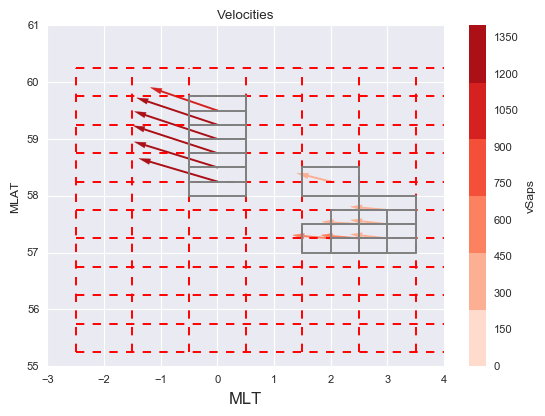

In [10]:

#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
plotMLTs = velAnlysDF['grid_MLT'].unique().tolist()
plotMLATs = velAnlysDF['grid_MLAT'].unique().tolist()

velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (fitResultsDF["vSaps"].max() + 100.)*100/100 - (fitResultsDF["vSaps"].max() + 100.)%100
# velAnlysDF.plot( kind='scatter',
#               x='normMLT_x',
#               y='MLAT',
#               c='Vlos',
#               s=50., cmap=seaMap, ax=ax)

fitResultsDF.plot( kind='scatter',
              x='grid_normMLT',
              y='grid_MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocities" )
ax.set_ylim( [int(round(velAnlysDF['grid_MLAT'].min()))-1, \
              int(round(velAnlysDF['grid_MLAT'].max()))+1] )
ax.set_xlim( [int(round(velAnlysDF['grid_MLT'].min()))-1, \
              int(round(velAnlysDF['grid_MLT'].max()))] )

plotMLTends = fitResultsDF['plot_normMLTEnd'].tolist()
plotMLATends = fitResultsDF['plot_MLATEnd'].tolist()
plotMLTbegins = fitResultsDF['grid_MLT'].tolist()
plotMLATbegins = fitResultsDF['grid_MLAT'].tolist()
plotVelMagns = fitResultsDF['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.1, head_length=0.2, fc=currCol, ec=currCol)
        
# Overlay the larger grid - the standardized one!
stdPlotMLTs = numpy.sort( velAnlysDF['std_grid_MLT'].unique() ).tolist()
stdPlotMLTs = stdPlotMLTs + [ max(stdPlotMLTs) + 1. ]
stdPlotMLATs = numpy.sort( velAnlysDF['std_grid_MLAT'].unique() ).tolist()
stdPlotMLATs = stdPlotMLATs + [ max(stdPlotMLATs) + 0.5 ]
for currMLT in stdPlotMLTs :
    ax.plot( [currMLT, currMLT], [ min(stdPlotMLATs), max(stdPlotMLATs) ], 'r--' )
for currMLAT in stdPlotMLATs :
    ax.plot( [ min(stdPlotMLTs), max(stdPlotMLTs) ], [currMLAT, currMLAT], 'r--' )
        
# Overlay the cells where good fits came from
for frRows in fitResultsDF.iterrows():
    ax.plot( [ frRows[1]["grid_MLT_Begin"], frRows[1]["grid_MLT_Begin"] ], \
            [ frRows[1]["grid_MLAT_Begin"], frRows[1]["grid_MLAT_End"] ], '0.5' )
    ax.plot( [ frRows[1]["grid_MLT_Begin"], frRows[1]["grid_MLT_End"] ], \
            [ frRows[1]["grid_MLAT_Begin"], frRows[1]["grid_MLAT_Begin"] ], '0.5' )
    
    ax.plot( [ frRows[1]["grid_MLT_Begin"], frRows[1]["grid_MLT_End"] ], \
            [ frRows[1]["grid_MLAT_End"], frRows[1]["grid_MLAT_End"] ], '0.5' )
    ax.plot( [ frRows[1]["grid_MLT_End"], frRows[1]["grid_MLT_End"] ], \
            [ frRows[1]["grid_MLAT_Begin"], frRows[1]["grid_MLAT_End"] ], '0.5' )

# Overlay the cells with bad-fits
# for bfRows in badFitDF.iterrows():
#     ax.plot( [ bfRows[1]["grid_MLT_Begin"], bfRows[1]["grid_MLT_Begin"] ], \
#             [ bfRows[1]["grid_MLAT_Begin"], bfRows[1]["grid_MLAT_End"] ], 'b:' )
#     ax.plot( [ bfRows[1]["grid_MLT_Begin"], bfRows[1]["grid_MLT_End"] ], \
#             [ bfRows[1]["grid_MLAT_Begin"], bfRows[1]["grid_MLAT_Begin"] ], 'b:' )
    
#     ax.plot( [ bfRows[1]["grid_MLT_Begin"], bfRows[1]["grid_MLT_End"] ], \
#             [ bfRows[1]["grid_MLAT_End"], bfRows[1]["grid_MLAT_End"] ], 'b:' )
#     ax.plot( [ bfRows[1]["grid_MLT_End"], bfRows[1]["grid_MLT_End"] ], \
#             [ bfRows[1]["grid_MLAT_Begin"], bfRows[1]["grid_MLAT_End"] ], 'b:' )
    
ax.get_figure().savefig("../figs/fitVels-smallgrid.pdf",bbox_inches='tight')
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####

In [11]:
# print fitResultsDF.head(20)
#### Standardize the results ####
#### Standardize the results ####
#### Standardize the results ####

# In this section we need to get the results into a standard format
# We'll choose a standard grid! and first get all the good fits into
# the grid
stdMLTArr = []
stdMLATArr = []
vSapsArr = []
azimArr = []
vErrArr = []
azimErrArr = []
vLosMeanArr = []
vLosMaxArr = []
goodFitCheckArr = []

stdPlotMLTs = numpy.sort( velAnlysDF['std_grid_MLT'].unique() ).tolist()
stdPlotMLTs = stdPlotMLTs + [ max(stdPlotMLTs) + 1. ]
stdPlotMLATs = numpy.sort( velAnlysDF['std_grid_MLAT'].unique() ).tolist()
stdPlotMLATs = stdPlotMLATs + [ max(stdPlotMLATs) + 0.5 ]
# lshell fit of cells with good fits!
for crStdMLAT in stdPlotMLATs:
    for crStdMLT in stdPlotMLTs:
#         print crStdMLAT, crStdMLT, " centered-->", crStdMLAT + 0.25, crStdMLT + 0.5
        slctdMLT = crStdMLT + 0.5
        slctdMLAT = crStdMLAT + 0.25
        # Now check if there are any good fits in the selected MLT/MLAT
        selDataDF = fitResultsDF[ ( abs(fitResultsDF["grid_MLAT"] - slctdMLAT) <= 0.25 ) &\
                           ( abs(fitResultsDF["grid_MLT"] - slctdMLT) <= 0.5 )].reset_index(drop=True)
        if selDataDF.shape[0] > 0:
            # Now the important thing here is to deal with multiple values
            # Its probably best to keep things simple (for now at least!).
            # Just get the row with the lowest azim error (if there are multiple rows still)
            # then for lowest vel magn error!
            if selDataDF.shape[0] > 1 :
                velSapsMean = selDataDF["vSaps"].mean()
                velSapsStd = selDataDF["vSaps"].std()
                azimSapsMean = selDataDF["azim"].mean()
                azimSapsStd = selDataDF["azim"].std()
                # get row(s) with lowest azim error
                selDataDF = selDataDF[ selDataDF["velAzimPercentError"] == \
                                      selDataDF["velAzimPercentError"].min()\
                                     ].reset_index(drop=True)
                # if we still have multiple rows, get the row with lowest 
                # vel magn error!
                if selDataDF.shape[0] > 1 :
                    selDataDF = selDataDF[ selDataDF["velMagnPercentError"] == \
                                      selDataDF["velMagnPercentError"].min()\
                                     ].reset_index(drop=True)
            selVelMagn = round( selDataDF["vSaps"].tolist()[0], 2 )
            selVelAzim = round( selDataDF["azim"].tolist()[0], 2 )
            selVelMagnErr = round( selDataDF["velMagnPercentError"].tolist()[0], 2 )
            selVelAzimErr = round( selDataDF["velAzimPercentError"].tolist()[0], 2 )
            selVlosMax = selDataDF["vLosMax"].tolist()[0]
            selVlosMean = round( selDataDF["vLosMean"].tolist()[0], 2 )
            # Populate the values into corresponding arrays
            stdMLTArr.append( slctdMLT )
            stdMLATArr.append( slctdMLAT )
            vSapsArr.append( selVelMagn )
            azimArr.append( selVelAzim )
            vErrArr.append( selVelMagnErr )
            azimErrArr.append( selVelAzimErr )
            vLosMeanArr.append( selVlosMean )
            vLosMaxArr.append( selVlosMax )
            goodFitCheckArr.append( True )
print stdMLTArr
print stdMLATArr
# Now work on the cells with badFitting results
for crStdMLAT in stdPlotMLATs:
    for crStdMLT in stdPlotMLTs:
#         print crStdMLAT, crStdMLT, " centered-->", crStdMLAT + 0.25, crStdMLT + 0.5
        slctdMLT = crStdMLT + 0.5
        slctdMLAT = crStdMLAT + 0.25
        # Skip those values that are already present in goodfits
        if ( (slctdMLT in stdMLTArr) & (slctdMLAT in stdMLATArr) ):
#             print slctdMLAT, slctdMLT
            continue
        # for the given MLAT and MLT check if there are any badfit rows present
        badFitRowCheck = badFitDF[ ( abs(badFitDF["grid_MLAT"] - slctdMLAT) <= 0.25 ) &\
                           ( abs(badFitDF["grid_MLT"] - slctdMLT) <= 0.5 )].reset_index(drop=True)
        # IF there are no badFitRows closeby! Skip...
        if badFitRowCheck.shape[0] == 0:
            continue
        # Now check if there are any good fits close to the selected MLT/MLAT
        # Currently, we'll use +/- 1 hour MLT and 2 degrees MLAT
        selDataDF = fitResultsDF[ ( abs(fitResultsDF["grid_MLAT"] - slctdMLAT) <= 2. ) &\
                           ( abs(fitResultsDF["grid_MLT"] - slctdMLT) <= 1. )].reset_index(drop=True)
        if ( selDataDF.shape[0] == 0 ):
#             print "no good fits found close by!!!"
#             print slctdMLT, slctdMLAT
#             print badFitDF[ ["grid_MLAT", "grid_MLT"] ]
            continue
        # select closest location based on MLTs
        selDataDF["diff_MLT"] = selDataDF["grid_MLT"] - slctdMLT
        selDataDF["diff_MLAT"] = selDataDF["grid_MLAT"] - slctdMLAT
        minDiffMLT = selDataDF["diff_MLT"].abs().min()
        minDiffMlat = selDataDF["diff_MLAT"].abs().min()
        # Get the closest MLT first and then select the closest latitude
        if ( minDiffMLT == 0. ):
            selDataDF = selDataDF[ selDataDF["diff_MLT"] == minDiffMLT ].reset_index(drop=True)
            selDataDF = selDataDF[ ( selDataDF["diff_MLAT"] == \
                                    selDataDF["diff_MLAT"].abs().min() ) |\
                                    ( selDataDF["diff_MLAT"] == \
                                    -1*selDataDF["diff_MLAT"].abs().min() ) ]\
                                    .reset_index(drop=True)
            # If we get only one value use it.
            if selDataDF.shape[0] == 1:
                nearestAzim = selDataDF["azim"].values[0]
                nearestVlosMax = selDataDF["vLosMax"].values[0]
                nearestAzimErr = selDataDF["velAzimPercentError"].values[0]
                nearestVSapsErr = selDataDF["velMagnPercentError"].values[0]
                nearestVlosMean = selDataDF["vLosMean"].values[0]
            # If we find multiple values choose the one with min error (PERCENT!!!) in azim
            else:
                selDataDF = selDataDF[ ( selDataDF["velAzimPercentError"] == selDataDF["velAzimPercentError"].abs().min() ) |\
                                      ( selDataDF["velAzimPercentError"] == -1*selDataDF["velAzimPercentError"].abs().min() ) ]
                # Now if we find multiple values, just choose one
                nearestAzim = selDataDF["azim"].values[0]
                nearestVlosMax = selDataDF["vLosMax"].values[0]
                nearestAzimErr = selDataDF["velAzimPercentError"].values[0]
                nearestVSapsErr = selDataDF["velMagnPercentError"].values[0]
                nearestVlosMean = selDataDF["vLosMean"].values[0]
        else:
            # Now we need to take care of +/- signs for MLTs as well
            selDataDF = selDataDF[ ( selDataDF["diff_MLT"] == \
                                    selDataDF["diff_MLT"].abs().min() ) |\
                                    ( selDataDF["diff_MLT"] == \
                                    -1*selDataDF["diff_MLT"].abs().min() ) ]\
                                    .reset_index(drop=True)
            # If we get only one value use it.
            if selDataDF.shape[0] == 1:
                nearestAzim = selDataDF["azim"].values[0]
                nearestVlosMax = selDataDF["vLosMax"].values[0]
                nearestAzimErr = selDataDF["velAzimPercentError"].values[0]
                nearestVSapsErr = selDataDF["velMagnPercentError"].values[0]
                nearestVlosMean = selDataDF["vLosMean"].values[0]
            else:
                selDataDF = selDataDF[ ( selDataDF["diff_MLAT"] == \
                                    selDataDF["diff_MLAT"].abs().min() ) |\
                                    ( selDataDF["diff_MLAT"] == \
                                    -1*selDataDF["diff_MLAT"].abs().min() ) ]\
                                    .reset_index(drop=True)
                # If we get only one value use it.
                if selDataDF.shape[0] == 1:
                    nearestAzim = selDataDF["azim"].values[0]
                    nearestVlosMax = selDataDF["vLosMax"].values[0]
                    nearestAzimErr = selDataDF["velAzimPercentError"].values[0]
                    nearestVSapsErr = selDataDF["velMagnPercentError"].values[0]
                    nearestVlosMean = selDataDF["vLosMean"].values[0]
                # If we find multiple values choose the one with min error (PERCENT!!!) in azim
                else:
                    selDataDF = selDataDF[ ( selDataDF["velAzimPercentError"] == selDataDF["velAzimPercentError"].abs().min() ) |\
                                          ( selDataDF["velAzimPercentError"] == -1*selDataDF["velAzimPercentError"].abs().min() ) ]
                    # Now if we find multiple values, just choose one
                    nearestAzim = selDataDF["azim"].values[0]
                    nearestVlosMax = selDataDF["vLosMax"].values[0]
                    nearestAzimErr = selDataDF["velAzimPercentError"].values[0]
                    nearestVSapsErr = selDataDF["velMagnPercentError"].values[0]
                    nearestVlosMean = selDataDF["vLosMean"].values[0]
        estSapsVel = nearestVlosMax[0]/( numpy.cos( \
                                    numpy.deg2rad( 90.-nearestAzim-nearestVlosMax[1] ) ) )
        # Populate the values into corresponding arrays
        stdMLTArr.append( slctdMLT )
        stdMLATArr.append( slctdMLAT )
        vSapsArr.append( round(estSapsVel,2) )
        azimArr.append( round(nearestAzim,2) )
        vErrArr.append( round(nearestVSapsErr,2) )
        azimErrArr.append( round(nearestAzimErr,2) )
        vLosMeanArr.append( round(nearestVlosMean,2) )
        vLosMaxArr.append( nearestVlosMax )
        goodFitCheckArr.append( False )

# Finally convert the values to a dataframe
lshellDF = pandas.DataFrame(
    {'normMLT': stdMLTArr,
     'MLAT': stdMLATArr,
     'vSaps': vSapsArr,
     'azim': azimArr,
     'vMagnErr': vErrArr,
     'azimErr': azimErrArr,
     'vLosMean': vLosMeanArr,
     'vLosMax': vLosMaxArr,
     'goodFitCheck': goodFitCheckArr
    })
# Plotting end points of vectors
lshellDF["plot_MLATEnd"] = numpy.round( (lshellDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*lshellDF["azim"]) ) +\
                                lshellDF["MLAT"], 2)
lshellDF["plot_normMLTEnd"] = numpy.round( (lshellDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*lshellDF["azim"]) ) +\
                                lshellDF["normMLT"], 2)
lshellDF.head(50)
print "NEED TO STORE DF DATA AS TUPLES!!"
#### Standardize the results ####
#### Standardize the results ####
#### Standardize the results ####

[2.0, 3.0, 2.0, 3.0, 0.0, 2.0, 3.0, 0.0, 2.0, 0.0, 0.0]
[57.0, 57.0, 57.5, 57.5, 58.0, 58.0, 58.0, 58.5, 58.5, 59.0, 59.5]
NEED TO STORE DF DATA AS TUPLES!!


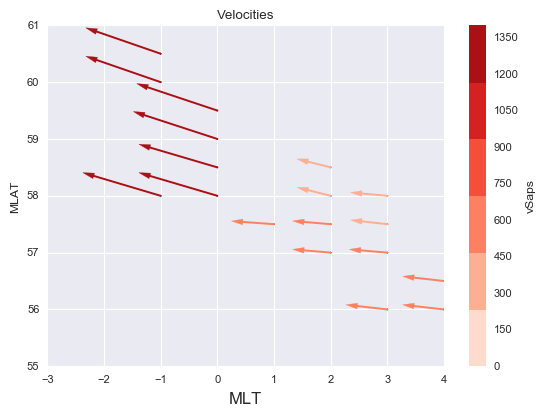

In [12]:
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
plotMLTs = velAnlysDF['grid_MLT'].unique().tolist()
plotMLATs = velAnlysDF['grid_MLAT'].unique().tolist()

velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (lshellDF["vSaps"].max() + 100.)*100/100 - (lshellDF["vSaps"].max() + 100.)%100

lshellDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocities" )
ax.set_ylim( [int(round(velAnlysDF['grid_MLAT'].min()))-1, \
              int(round(velAnlysDF['grid_MLAT'].max()))+1] )
ax.set_xlim( [int(round(velAnlysDF['grid_MLT'].min()))-1, \
              int(round(velAnlysDF['grid_MLT'].max()))] )

plotMLTends = lshellDF['plot_normMLTEnd'].tolist()
plotMLATends = lshellDF['plot_MLATEnd'].tolist()
plotMLTbegins = lshellDF['normMLT'].tolist()
plotMLATbegins = lshellDF['MLAT'].tolist()
plotVelMagns = lshellDF['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.1, head_length=0.2, fc=currCol, ec=currCol)

ax.get_figure().savefig("../figs/lShellVels-grid.pdf",bbox_inches='tight')
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####
#### Plot the fitted SAPS velocities ####

In [13]:
print "NEED TO STORE DF DATA AS TUPLES!!"

NEED TO STORE DF DATA AS TUPLES!!
